# **PRELIMINARY INFORMATION**

This Notebook is devoted to the Feature Engineering of the **entire dataset**. 

The idea is to clusterize data in a best possible way using **K-means++ clustering**  along with different **feature engineering (FE)** techniques.

*Note-1:* If during re-execution of the code some plots are not drawn in a large scale, execution of the cell one more time could help:)

*Note-2:* Some passages/functions/commentsries (e.g. Set Up block) are repetetive with the previous Notebook for the sake of keeping information in order.

# **SET UP**

## **Imports**

In [1]:
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import re
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import cdist
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
import random
import timeit

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
#for the repeatability of the experiments
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)

## **Get and Unzip the Dataset**

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [6]:
!kaggle datasets download -d najzeko/steam-reviews-2021

100% 2.97G/2.97G [00:46<00:00, 33.9MB/s]



In [7]:
!unzip \*.zip  && rm *.zip

Archive:  steam-reviews-2021.zip
replace steam_reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## **Load Dataset in Pandas**

In order to fit into a local memory, we read dataset with a **chunksize** parameter.

In [8]:
chunk_df = pd.read_csv('steam_reviews.csv', chunksize=3000000)

Now with a simple cycle we can extract any number of chunks of data to perform experiments. 

Let's take just one chunk, corresponding to the **~450MB** of data.

In [9]:
for data in chunk_df:
    chunk = data
    break

In [10]:
#print dataset info to see fields specifications and check dataset memory consumption
chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 23 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   app_id                          int64  
 2   app_name                        object 
 3   review_id                       int64  
 4   language                        object 
 5   review                          object 
 6   timestamp_created               int64  
 7   timestamp_updated               int64  
 8   recommended                     bool   
 9   votes_helpful                   int64  
 10  votes_funny                     int64  
 11  weighted_vote_score             float64
 12  comment_count                   int64  
 13  steam_purchase                  bool   
 14  received_for_free               bool   
 15  written_during_early_access     bool   
 16  author.steamid                  int64  
 17  author.num_games_owned     

## **Preliminary Cleaning and Partitioning**

Although the first clustering will be performed without any feature engineering technique applied, we still need to clean up the data to represent it in a form, appropriate for the input of clustering routine.

1. As it was noted by using Data Explorer provided by Kaggle web-page, that dataset contains reviwes from users all over the world (i.e. in different languages). Let's first **filter out all the non-english reviwes**.

In [11]:
df = chunk[chunk['language']=='english']

In [12]:
#drop language field, since it doesn't contain any relevant information for the clustering anymore
df = df.drop(['language'], axis = 1)

In [13]:
#check the size of new dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318048 entries, 3 to 2999997
Data columns (total 22 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Unnamed: 0                      1318048 non-null  int64  
 1   app_id                          1318048 non-null  int64  
 2   app_name                        1318048 non-null  object 
 3   review_id                       1318048 non-null  int64  
 4   review                          1315805 non-null  object 
 5   timestamp_created               1318048 non-null  int64  
 6   timestamp_updated               1318048 non-null  int64  
 7   recommended                     1318048 non-null  bool   
 8   votes_helpful                   1318048 non-null  int64  
 9   votes_funny                     1318048 non-null  int64  
 10  weighted_vote_score             1318048 non-null  float64
 11  comment_count                   1318048 non-null  int64  
 12  

2. The second step of Preliminary Cleaning is **duplicates and nulls removal**. Regarding to the former: the check of the presence of duplicates has shown that they are not present in a given dataset, regarding to the latter: nulls are removed in a "total" fasion, i.e. whichever column they are contained in.

In [14]:
df = df.dropna(axis = 0, how = 'any')

Now `df` $-$ raw dataframe to work on.

In [15]:
#preview of the dataframe
pd.set_option('display.max_colwidth', 100)
print("DATASET SHAPE:\n\n", df.shape, "\n\nDATASET:\n")
df.head(3)

DATASET SHAPE:

 (1313324, 22) 

DATASET:



,Unnamed: 0,app_id,app_name,review_id,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
3,3,292030,The Witcher 3: Wild Hunt,85184605,"One of the best RPG's of all time, worthy of any collection",1611379970,1611379970,True,0,0,0.0,0,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09
5,5,292030,The Witcher 3: Wild Hunt,85184171,"good story, good graphics. lots to do.",1611379264,1611379264,True,0,0,0.0,0,True,False,False,76561198170193529,11,1,823.0,823.0,823.0,1.611379e+09
6,6,292030,The Witcher 3: Wild Hunt,85184064,"dis gud,",1611379091,1611379091,True,0,0,0.0,0,True,False,False,76561198119302812,27,2,4192.0,3398.0,4192.0,1.611352e+09


To **speed up** computations during the experiments the smaller portion of data will be used.

Therefore, we **create mini-dataframe** `df_mini` by sampling `n` random rows of `df` (parameter `n` can vary, this time we take `n = 5000`).

In [16]:
df_mini = df.sample(n = 5000)
print("MINI DATASET SHAPE:\n\n", df_mini.shape)

MINI DATASET SHAPE:

 (5000, 22)


# **UTILITIES**

Utility `get_clusters` in a cell below takes as INPUT: 

1. Desired **number of clusters** `n_clusters`;
2. The **dataset** `data` to be clusterized with K-means++, 

and returns as OUTPUT the **model** `kmeans`.

In [17]:
def get_clusters(n_clusters, data):

  kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++')
  kmeans.fit(data)
  
  return kmeans

Utility `plot_heatmap` in a cell below takes as INPUT the **dataframe** `df` with the joined "clusters" column,

and DISPLAYS **two heatmaps** to see: 

1. If the **recommended** items are clustered together;
2. If the **purhased** items are clustered together.

In [18]:
def plot_heatmap(df):

  #performing grouping
  #normalization is done due to the fact that dataset is not balanced and there are significantly more recommended items than not recommended
  recommendation_clusters = df.groupby(['cluster', 'recommended']).size() / df.groupby(['recommended']).size()

  fig, ax1 = plt.subplots(figsize = (16, 7))
  sns.heatmap(recommendation_clusters.unstack(level = 'recommended'), ax = ax1, cmap = 'Reds')
  ax1.set_xlabel('recommended').set_size(14)
  ax1.set_ylabel('cluster').set_size(14)

  purchasing_clusters = df.groupby(['cluster', 'steam_purchase']).size() / df.groupby(['steam_purchase']).size()

  fig, ax2 = plt.subplots(figsize = (16, 7))
  sns.heatmap(purchasing_clusters.unstack(level = 'steam_purchase'), ax = ax2, cmap = "Blues")
  ax2.set_xlabel('steam_purchase').set_size(14)
  ax2.set_ylabel('cluster').set_size(14)

Utility `plot_scatter` in a cell below takes as INPUT: 

1. The **number of components** `n_components` to keep in **PCA**;
2. The **dataframe** `df` with the joined `"clusters"` column;
3. The **number of items to sample** from dataframe for plotting `sample_size`;
4. The **vectorizer** `tfv`;
5. The **mode** of the experimental set-up `mode`,

and DISPLAYS the **scatter plot of clustering** in 2D or 3D.

In [19]:
def plot_scatter(n_components, df, tfv=None, mode="wfe"):

  if mode == "wfe":
    data = prepared_input_wfe(df, tfv)
  elif mode == "sin":
    data = prepared_input_sin(df, tfv)
  elif mode == "nlp":
    _, data = prepared_input_nlp(df)
  elif mode == "pca":
    _, data = prepared_input_pca(df, 3)

  
  #project to lower dimensions
  pca = PCA(n_components = n_components)
  Xtrain_pca = pca.fit_transform(data)
    
  Ytrain_plot = df['cluster']

  if n_components == 2:
    plt.figure()
    plt.title("Scatter plot of clustered data in 2D")
    plt.scatter(Xtrain_pca[:,0], Xtrain_pca[:,1], c = Ytrain_plot, cmap = 'jet')
    plt.rcParams["figure.figsize"] = (12, 8)
    if mode == "sin" or mode == "pca":
      plt.xlim(-3,12)
      plt.ylim(-15,10)
    if mode == "nlp":
      plt.xlim(-2,7)
      plt.ylim(-8,6)
    plt.savefig("Scatter plot of clustered data in 2D mode {}".format(mode))
    plt.show()

  if n_components == 3:
    fig = plt.figure()
    ax = Axes3D(fig)
    plt.title("Scatter plot of clustered data in 3D")
    ax.scatter(Xtrain_pca[:,0], Xtrain_pca[:,1], Xtrain_pca[:,2], c = Ytrain_plot, cmap = 'jet')
    if mode == "sin" or mode == "pca":
      ax.set_xlim(-5,6)
      ax.set_ylim(-5,6)
      ax.set_zlim(-5,6)
    if mode == "nlp":
      ax.set_xlim(-5,7)
      ax.set_ylim(-5,25)
      ax.set_zlim(-10,8)
    plt.savefig("Scatter plot of clustered data in 3D mode {}".format(mode))
    plt.show()

# **CLUSTERING**

**K-means++** clustering technique has been chosen and implemented exploiting **Scikit-Learn** library. 

Four different experimental set-ups (approaches) for the clustering are implemented below:

> 1. **Without FE** (`mode = "wfe"`): just on raw data;

> **With FE**:

>> 2. Feature Selection, Invention and Normalization (`mode = "sin"`);

>> 3. NLP (textual data preprocessing and embeddings) (`mode = "nlp"`);

>> 4. PCA (`mode = "pca"`).

Each of the set-ups encouters the following **stages**:  

*   Preparation of the input data for the clustering;
*   Fitting the model with prepared data and fixed `k = 20`;
*   Plotting the results.

*Note-1:* Utilities for fitting and plotting are essentially the same in all approaches, meanwhile utility for the preparation of the input data is individual and determines the approach.

*Note-2:* The more detailed analysis as well as motivation behind chosen approaches can be found in the **report**.

## **WITHOUT FE**

### **Preparation of the input data for the clustering**

Original Dataset contains fields with the different data types. 

In particular, two of them are textual and require vectorization to be fed into clusterizer. So, these two fields, namely `"app_name"` and `"review"`, are **taken separately** from the rest of Dataset, **converted** into a matrix of TF-IDF features using our old friend TfidfVectorizer **and concatenated back** with other fields. 

Now all the fields are either **digital** or automatically convertable to digital during clustering, and therefore we can proceed with further steps of experimental set-up.

*Note:* It's rather obvious that actually some fields such as **unique identifiers** are auxiliary for clustering and can only contribute to degradation of it's quality per se, but for the fair realization of `"wfe" mode` they **are left untouched**.

In [20]:
tfv_wfe = TfidfVectorizer(ngram_range = (1,1))
def prepared_input_wfe(df, tfv):

  #leave only digital fields
  df_without_text = df.drop(['app_name', 'review'], axis = 1)

  #review vectorization
  vectorized_review = tfv.fit_transform(df['review'])
  review = np.array(vectorized_review.todense())

  #app_name vectorization
  vectorized_name = tfv.fit_transform(df_mini['app_name'])
  name = np.array(vectorized_name.todense())

  #concatenation of all fields into a single input
  input = np.concatenate((review, name, df_without_text.values), axis = 1)
  del review
  del name
  return input

In [21]:
#resulting data type and shape
data_wfe = prepared_input_wfe(df_mini.copy(), tfv_wfe)

In [22]:
#resulting data is quite sparse
print("DATA SHAPE:\n\n", data_wfe.shape, "\n\nDATA:\n")
data_wfe

DATA SHAPE:

 (5000, 11615) 

DATA:



array([[0.0, 0.0, 0.0, ..., 0.0, 2451.0, 1590167871.0],
       [0.0, 0.0, 0.0, ..., 468.0, 399.0, 1610773026.0],
       [0.0, 0.0, 0.0, ..., 102.0, 40608.0, 1610145127.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 392.0, 1609655760.0],
       [0.0, 0.0, 0.0, ..., 763.0, 2691.0, 1610764540.0],
       [0.0, 0.0, 0.0, ..., 0.0, 49886.0, 1603759009.0]], dtype=object)

### **Fitting the model with prepared data and fixed `k = 20`**

In [23]:
start = timeit.default_timer()

kmeans_wfe = get_clusters(20, data_wfe)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  87.36319497400007


### **Plotting the results**

**1. Visualize the heatmaps to see how recommendations and purchases are clustered**

In [24]:
#add the cluster label to the dataframe
df_wfe = df_mini.copy()
df_wfe['cluster'] = kmeans_wfe.labels_

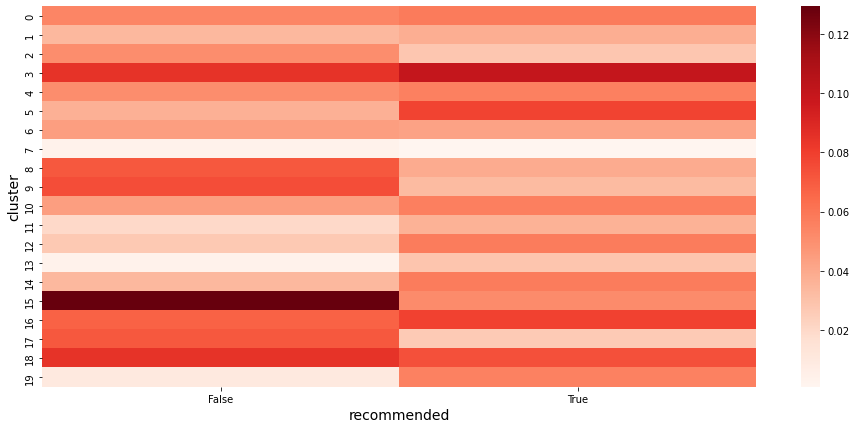

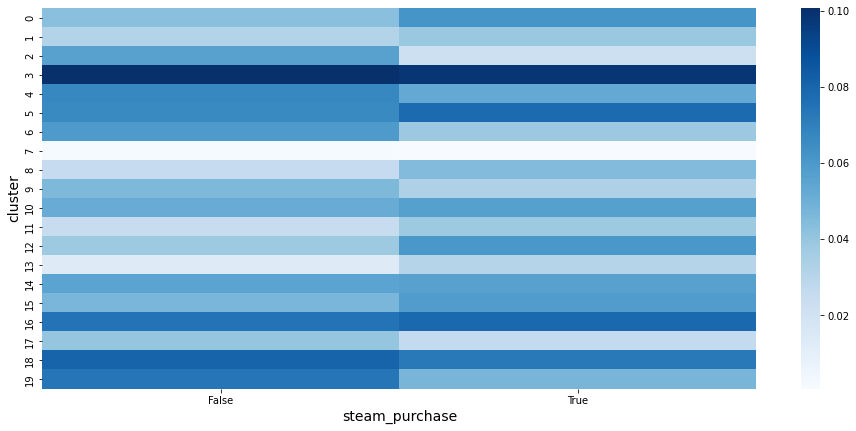

In [25]:
plot_heatmap(df_wfe)

**Conclusion from plots:** Finally, some progresses of the Heatmap are observable: users, who didn't recommend an item, seem to be concentrated in a cluster 15.

**2. Plots of the clusters with data projected to 2D and 3D using `pca` from Scikit Learn**

Let's take a look on the scatter plots of the portion of the entire raw dataset.

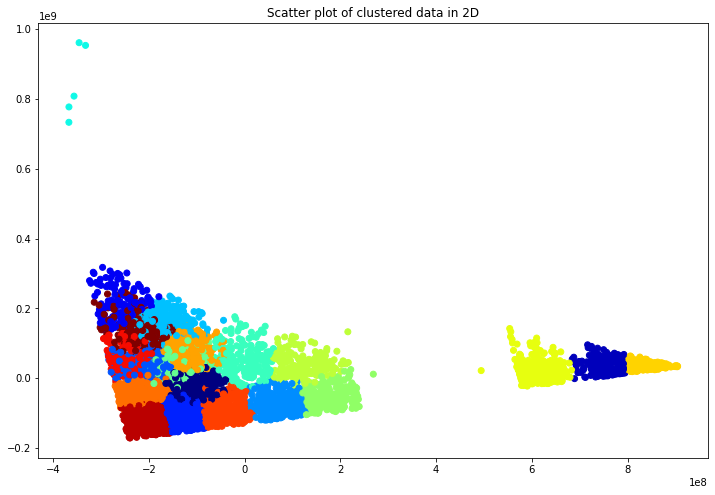

In [27]:
#2D scatter plot
#execute twice to get large scale
plot_scatter(2, df_wfe, tfv_wfe, "wfe")

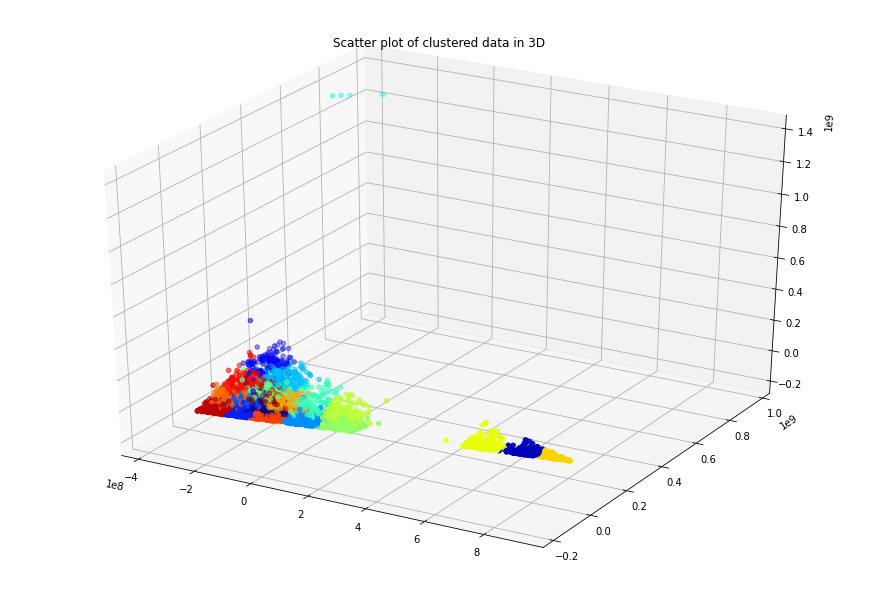

In [28]:
#3D scatter plot
plot_scatter(3, df_wfe, tfv_wfe, "wfe")

**Conclusion from plots:** No spatial patterns are captured, projected data is just divided between the clusters in a systematic fasion, feature engineering techniques are needed.

## **FE: FEATURE SELECTION, INVENTION AND NORMALIZATION**

An idea is to prepare better structured data input for the clustering algorithm. 

So, in this experimental set-up instead of working with the raw data, we will **inspect the dataset** and perform Feature Selection, Invention (Development) and Normalization.

### **Preparation of the input data for the clustering**

**1. Feature Selection**

Feature Selection (FS) is the procedure that considers reducing of the number of input variables by **removal** from the dataset the features that are **not statistically meaningful**.






The most appropriate choice of **columns to be dropped** from a given dataframe assumingly is:


*   `"Unnamed: 0"` $-$ excessive duplicate of dataframe index;
*   `"review_id"` $-$ is unique for each review (doesn't bring statistically meaningful information);
*    `"app_id"` $-$ level of uniqueness corresponds to one of the `"app_name" `column (one could do the opposite and drop `"app_name"` instead);
*    `"author.steamid"` $-$ is nor statistically meaningful enough (would make sense to keep for some specific tasks, e.g. "active users" detection, but that goes beyond current area of interest);
*    Timestamps and data fields: `"timestamp_created", "timestamp_updated", "author.last_played"` $-$ don't reflect user preferences per se and therefore are not useful for the grouping (although they are important to follow the time evolution, but this is out of the area of interest for a time being);
*    `"weighted_vote_score"` $-$ score based on number of helpful votes (highly correlated with `"votes_helpful"`).


*Note:* Some "time" fields, namely `"author.playtime_forever", "author.playtime_last_two_weeks",	"author.playtime_at_review"`, are kept, because they determine an author's review validity.

In [29]:
df_sin = df.copy()
print("DATAFRAME SHAPE BEFORE FS:\n\n", df_sin.shape)
df_sin = df_sin.drop(['Unnamed: 0', 'review_id', 'app_id', 
                    'timestamp_created', 'timestamp_updated', 'weighted_vote_score',
                    'author.steamid', 'author.last_played'], axis=1)

#preview of the dataframe after feature selection
pd.set_option('display.max_colwidth', 100)
print("\nDATAFRAME SHAPE AFTER FS:\n\n", df_sin.shape, "\n\nDATAFRAME AFTER FS:\n")
df_sin.head(3)

DATAFRAME SHAPE BEFORE FS:

 (1313324, 22)

DATAFRAME SHAPE AFTER FS:

 (1313324, 14) 

DATAFRAME AFTER FS:



,app_name,review,recommended,votes_helpful,votes_funny,comment_count,steam_purchase,received_for_free,written_during_early_access,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review
3,The Witcher 3: Wild Hunt,"One of the best RPG's of all time, worthy of any collection",True,0,0,0,True,False,False,5,3,5587.0,3200.0,5524.0
5,The Witcher 3: Wild Hunt,"good story, good graphics. lots to do.",True,0,0,0,True,False,False,11,1,823.0,823.0,823.0
6,The Witcher 3: Wild Hunt,"dis gud,",True,0,0,0,True,False,False,27,2,4192.0,3398.0,4192.0


**2. Feature Development**

Let's also **add a couple features** helpful for our predictive model:

*   `"word_count"` $-$ the number of words in review (hypothesis: longer reviews might be associated with tendency to (not)recommend app);
*   `"has_expertise"` $-$ binary field to signify whether or not user is an experienced enough player (user is considered to be experienced enough if his `"author.playtime_forever"` is larger than average over reviews in dataframe).

For both feature inventions we need to perform **preliminary analysis**.

WORD_COUNT

First of all, we want to check if adding such a feature indeed could make some sense, i.e. to **check the hypothesis** that length of review is correlated with binary reviewer's feedback `"recommended"`.

In [30]:
#add a column with word counts to a dataframe
df_sin['word_count'] = df_sin['review'].apply(lambda x: len(str(x).split(" ")))
df_sin.head(3)

,app_name,review,recommended,votes_helpful,votes_funny,comment_count,steam_purchase,received_for_free,written_during_early_access,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,word_count
3,The Witcher 3: Wild Hunt,"One of the best RPG's of all time, worthy of any collection",True,0,0,0,True,False,False,5,3,5587.0,3200.0,5524.0,12
5,The Witcher 3: Wild Hunt,"good story, good graphics. lots to do.",True,0,0,0,True,False,False,11,1,823.0,823.0,823.0,7
6,The Witcher 3: Wild Hunt,"dis gud,",True,0,0,0,True,False,False,27,2,4192.0,3398.0,4192.0,2


In [31]:
#print percentage of reviews with length of review larger than 300
round(df_sin[df_sin['word_count']>300].shape[0]/df_sin.shape[0], 2)

0.01

**Conclusion:** Just 1% of reviews has length of review larger than 300 words, i.e. we can **neglect** such reviews during word counts analysis.

Word Count Median: 10.0
count    1.295022e+06
mean     2.509390e+01
std      4.105265e+01
min      1.000000e+00
25%      3.000000e+00
50%      1.000000e+01
75%      2.700000e+01
max      2.990000e+02
Name: word_count, dtype: float64


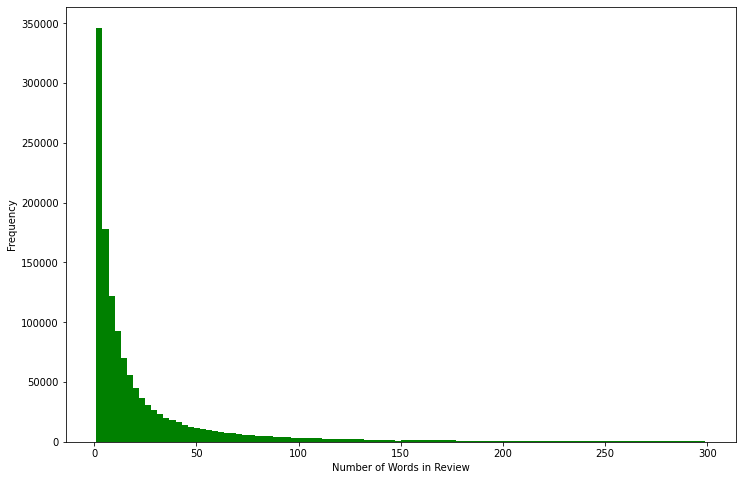

In [32]:
print("Word Count Median: " + str(df_sin['word_count'][df_sin['word_count']<300].median()))
print(df_sin['word_count'][df_sin['word_count']<300].describe())

X = df_sin['word_count'][df_sin['word_count']<300]

plt.hist(X, bins = 100, color='g')
plt.xlabel('Number of Words in Review')
plt.ylabel('Frequency')
plt.show()

**Conclusion:** The median of word counts is around `med = 10`. 

Now we can check the data distribution in the `"recommended"` column for the both tails, obtained after **splitting at the median point**.

count     647144
unique         2
top         True
freq      623650
Name: recommended, dtype: object


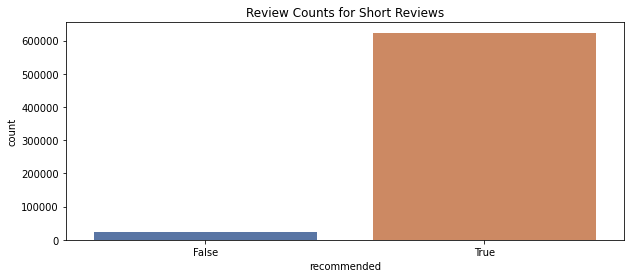

count     632308
unique         2
top         True
freq      574659
Name: recommended, dtype: object


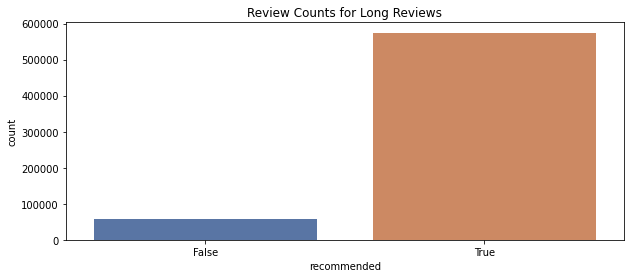

In [33]:
def plot_countplots_wc(df, med, mode = "l"):

  if mode == "l":
    wc = df.loc[df['word_count'] < med]
    s = 'Short'
  else:
    wc = df.loc[df['word_count'] > med]
    s = 'Long'

  print(wc.recommended.describe())

  plt.figure(figsize = (10, 4))
  sns.countplot(x ='recommended', data = wc, palette="deep").set_title("Review Counts for {} Reviews".format(s))
  plt.show()


#median
med = 10
plot_countplots_wc(df_sin, med, "l")
plot_countplots_wc(df_sin, med, "g")

**Conclusion:** Long review could be helpful to detect reviewers with negative feedback, therefore it makes sense to **keep invented feature** as an input value for the clustering.

*Note:* Announced earlier **"unbalanced"** property of a dataframe over a value of interest (significantly larger amount of reviewers who recommends an app than those who don't recommend) **is confirmed**.

HAS_EXPERTISE

To estimate wether the player is experienced or not, we need first to **compute average playtime**, and that can be done using `"author.playtime_forever"` data column $-$ author lifetime playtime of reviewed app.

In [34]:
#we check only the number of unique values
print("Number of Unique Values: " + str(len(df_sin['author.playtime_forever'].unique())))
#average playtime amongst unique once
avg = round(np.average(df_sin['author.playtime_forever'].unique()))
print("Average Playtime:", avg)

Number of Unique Values: 132203
Average Playtime: 106196


**Binary column**, representing wether the playtime of a given reviewer is higher than average, can be added to a dataframe now. 

And then we can plot the data distribution in the `"recommended"` column for the experienced or not reviewers.

In [35]:
df_sin['has_expertise'] = [1 if playtime > avg else 0 for playtime in df_sin['author.playtime_forever']]
df_sin.head(3)

,app_name,review,recommended,votes_helpful,votes_funny,comment_count,steam_purchase,received_for_free,written_during_early_access,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,word_count,has_expertise
3,The Witcher 3: Wild Hunt,"One of the best RPG's of all time, worthy of any collection",True,0,0,0,True,False,False,5,3,5587.0,3200.0,5524.0,12,0
5,The Witcher 3: Wild Hunt,"good story, good graphics. lots to do.",True,0,0,0,True,False,False,11,1,823.0,823.0,823.0,7,0
6,The Witcher 3: Wild Hunt,"dis gud,",True,0,0,0,True,False,False,27,2,4192.0,3398.0,4192.0,2,0


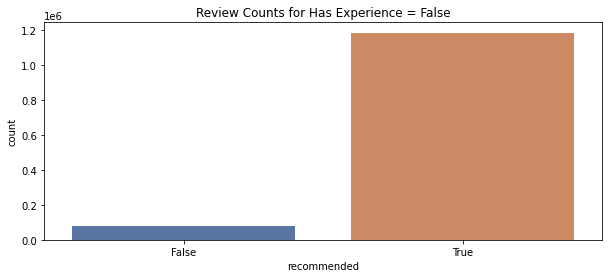

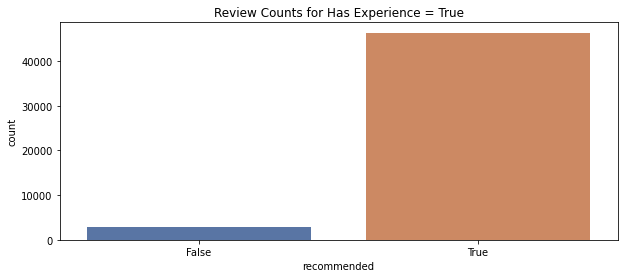

In [36]:
def plot_countplots_he(df, mode = 1):

  wc = df.loc[df['has_expertise'] == mode]

  plt.figure(figsize = (10, 4))
  sns.countplot(x ='recommended', data = wc, palette="deep").set_title("Review Counts for Has Experience = {}".format(bool(mode)))
  plt.show()

plot_countplots_he(df_sin, 0)
plot_countplots_he(df_sin, 1)

**3. Normalization**

As a final step of the current set up, **Data Normalization** has to be performed, because until now dataframe each column of the dataframe has different value range, which negatively influences on the performance of the clustering model.

So, we extract numeric columns and **transform them to a common scale** with **mean normalization** (subtract mean and divide by standard deviation).


In [37]:
df_without_text = df_sin.drop(['app_name', 'review'], axis = 1)
normalized_df = (df_without_text - df_without_text.mean()) / df_without_text.std()
normalized_df.head(3)

,recommended,votes_helpful,votes_funny,comment_count,steam_purchase,received_for_free,written_during_early_access,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,word_count,has_expertise
3,0.259189,-0.047418,-0.005854,-0.07267,0.502859,-0.161426,-0.214412,-0.519647,-0.249627,-0.268323,4.719457,-0.172451,-0.256354,-0.197505
5,0.259189,-0.047418,-0.005854,-0.07267,0.502859,-0.161426,-0.214412,-0.497647,-0.308772,-0.357800,1.075149,-0.298453,-0.319970,-0.197505
6,0.259189,-0.047418,-0.005854,-0.07267,0.502859,-0.161426,-0.214412,-0.438980,-0.279199,-0.294524,5.023021,-0.208153,-0.383586,-0.197505


**Conclusion:** Now no column dominates the learning process, and we are ready to **join** Feature Selection, Feature Invention, Normalization (of the numeric columns) and Vectorization (of the textual columns) into a single **data preparation routine**.

In [38]:
tfv_sin = TfidfVectorizer(ngram_range = (1,1))
def prepared_input_sin(df, tfv):

  #feature selection
  df = df.drop(['Unnamed: 0', 'review_id', 'app_id', 
                    'timestamp_created', 'timestamp_updated', 'weighted_vote_score',
                    'author.steamid', 'author.last_played'], axis = 1)
  
  #feature invention: add word counting feature
  df['word_count'] = df['review'].apply(lambda x: len(str(x).split(" ")))

  #compute average playtime amongst unique playtimes
  avg = np.average(df['author.playtime_forever'].unique())
  #feature invention: add has expertise feature
  df['has_expertise'] = [1 if playtime > avg else 0 for playtime in df['author.playtime_forever']]
  
  #leave only digital fields
  df_without_text = df.drop(['app_name', 'review'], axis = 1)

  #data vectorization: review vectorization
  vectorized_review = tfv.fit_transform(df['review'])
  review = np.array(vectorized_review.todense())

  #data vectorization: app_name vectorization
  vectorized_name = tfv.fit_transform(df['app_name'])
  name = np.array(vectorized_name.todense())

  #data normalization
  normalized_df = (df_without_text - df_without_text.mean()) / df_without_text.std()

  #concatenation of all fields into a single input
  input = np.concatenate((review, name, normalized_df.values), axis = 1)
  del review
  del name

  return input

In [39]:
#resulting data type and shape
data_sin = prepared_input_sin(df_mini.copy(), tfv_sin)

In [40]:
#resulting data is quite sparse
print("DATA SHAPE:\n\n", data_sin.shape, "\n\nDATA:\n")
data_sin

DATA SHAPE:

 (5000, 11609) 

DATA:



array([[ 0.        ,  0.        ,  0.        , ..., -0.24859087,
        -0.39536502, -0.48490291],
       [ 0.        ,  0.        ,  0.        , ..., -0.29840931,
        -0.40749546, -0.48490291],
       [ 0.        ,  0.        ,  0.        , ...,  0.67778447,
         2.77067993,  2.06185606],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.29857925,
        -0.39536502, -0.48490291],
       [ 0.        ,  0.        ,  0.        , ..., -0.24276415,
        -0.21340841, -0.48490291],
       [ 0.        ,  0.        ,  0.        , ...,  0.90303568,
        -0.39536502,  2.06185606]])

### **Fitting the model with prepared data and fixed `k = 20`**

In [41]:
start = timeit.default_timer()

kmeans_sin = get_clusters(20, data_sin)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  74.2761187829999


### **Plotting the results**

**1. Visualize the heatmaps to see how recommendations and purchases are clustered**

In [42]:
#add the cluster label to the dataframe
df_sin_mini = df_mini.copy()
df_sin_mini['cluster'] = kmeans_sin.labels_

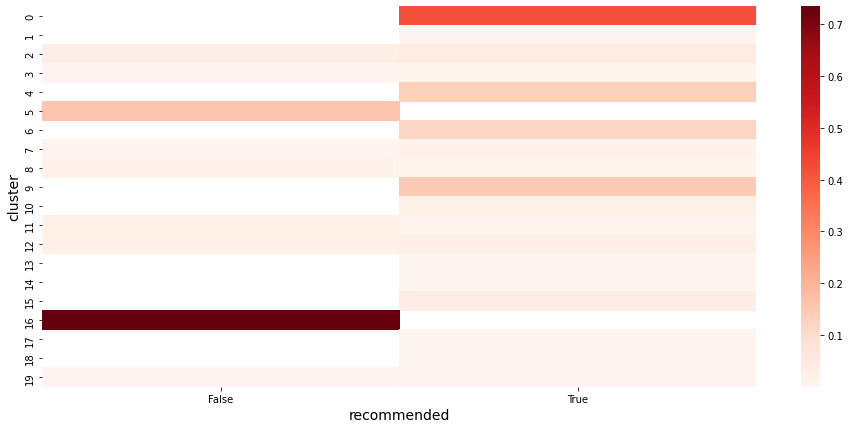

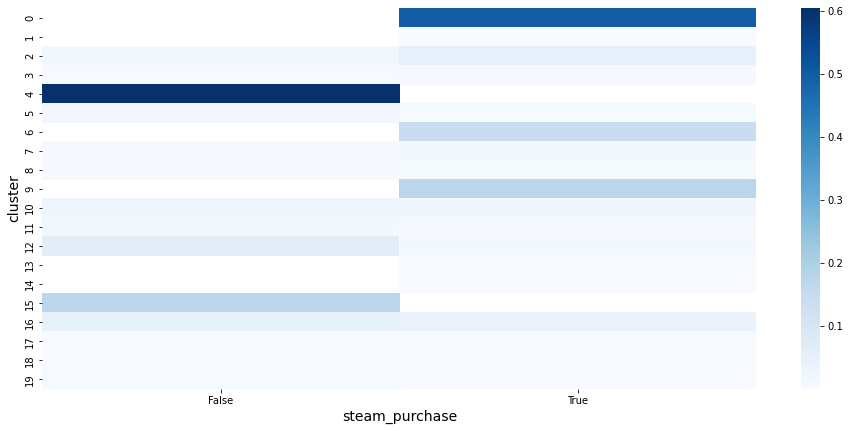

In [43]:
plot_heatmap(df_sin_mini)

**Conclusion from plots:** Finally, clustering really works over two areas of interest, because recommended apps are heavily distriuted into one of the clusters, meanwhile not recommended ones $-$ into anothe one, and purchased vs not purchased between the clusters the different clusters as well. The only doubt is that: we actually fed the columns of interest into clustering model, so **the result could be misleading**.

**2. Plots of the clusters with data projected to 2D and 3D using `pca` from Scikit Learn**

Now let's see what is going on on the scatter plots after enforcement to perform basic reasonable feature engineering has been performed.

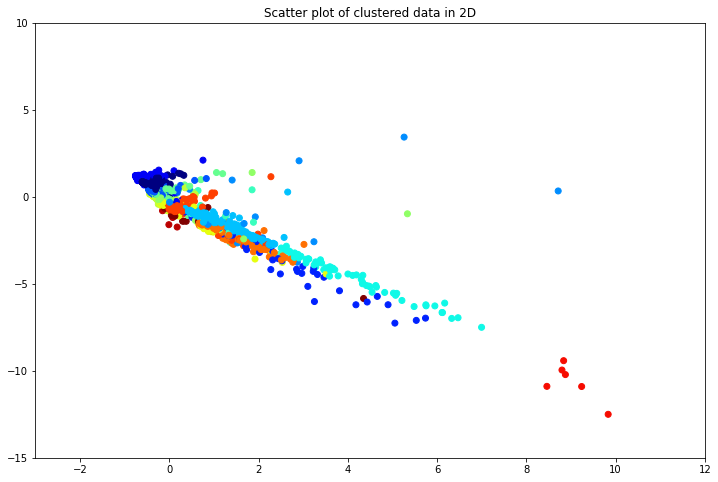

In [44]:
#2D scatter plot
plot_scatter(2, df_sin_mini, tfv_sin, "sin")

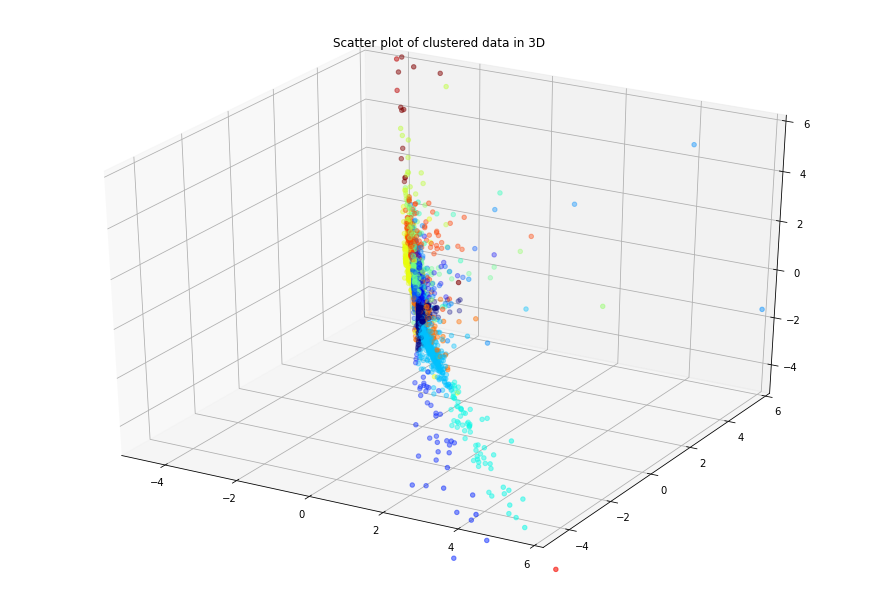

In [45]:
#3D scatter plot
plot_scatter(3, df_sin_mini, tfv_sin, "sin")

**Conclusion from plots:** Clustering is actually performed! Cannot say that perfectly, but some of the patterns are captured.

## **FE: NLP (textual data preprocessing and embeddings)**

An idea is to get an improvement of the results by combining **"the best of two worlds"**: employing the best found so far approach to the preprocessing of the textual field (text preprocessing+word embeggings using Global Vectors of dimensionality 100d loaded as pre-trained) in addition to the Feature Selection, Invention and Normalization of the numerical fileds.

*Note:* `"app_name"` field appears to be better dropped, than preprocessed.

### **Preparation of the input data for the clustering**

In [46]:
#get GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
#rm all except for 100d
!rm glove.6B.50d.txt
!rm glove.6B.200d.txt
!rm glove.6B.300d.txt
!rm glove.6B.zip

--2021-12-05 19:32:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-05 19:32:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-05 19:32:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [47]:
#create dictionary that maps words as strings to their embedding vectors
def load_embeddings(embeddings_path):

    word_vectors = dict()
    with open(embeddings_path) as f:

        for i, line in tqdm(enumerate(f)):

            word, *vector = line.strip().split(' ')
            vector = np.array([float(c) for c in vector])
            word_vectors[word] = vector

    return word_vectors
word_vectors = load_embeddings('glove.6B.100d.txt')

400000it [00:21, 19010.38it/s]


In [48]:
def prepared_input_nlp_text(review):
  review = review.apply(lambda x: x.lower()) #lowercasing
  review = review.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x)) #auxiliary characters removal
  review = review.apply(lambda x: re.sub(' +', ' ', x)) #auxiliary spaces removal
  review = review.apply(lambda x: [lemmatizer.lemmatize(token) for token in x.split() 
                                                              if not token in stop_words and len(token) > 2]) #split, stop-words removal and lemmatization
  #we replace each word with its embedding stored in the word_vectors dictionary
  review = review.apply(lambda x: [word_vectors[w] for w in x if w in word_vectors])
  #we stack embeddings for all the words in the sentence together 
  review = review.apply(lambda x: np.stack(x) if len(x) > 0 else x)
  #the mean embedding is computed to represent the whole sentence
  review = review.apply(lambda x:  np.mean(x, axis=0))
  #if during stop-words removal some sentences became empty, they will imply empty arrays as embeddings
  #and further NaNs as the result of computational procedure, which should be dropped
  review = review.dropna()
  return review

In [49]:
def prepared_input_nlp(df):

  #feature selection
  df = df.drop(['Unnamed: 0', 'review_id', 'app_id', 
                    'timestamp_created', 'timestamp_updated', 'weighted_vote_score',
                    'author.steamid', 'author.last_played', 'app_name'], axis = 1)
  
  #feature invention: add word counting feature
  df['word_count'] = df['review'].apply(lambda x: len(str(x).split(" ")))

  #compute average playtime amongst unique playtimes
  avg = np.average(df['author.playtime_forever'].unique())
  #feature invention: add has expertise feature
  df['has_expertise'] = [1 if playtime > avg else 0 for playtime in df['author.playtime_forever']]
  
  #leave only digital fields
  df_without_text = df.drop(['review'], axis = 1)

  #data normalization
  normalized_df = (df_without_text - df_without_text.mean()) / df_without_text.std()

  #review preprocessing
  review = prepared_input_nlp_text(df['review'])
  df = df[df.index.isin(review.index)]
  normalized_df = normalized_df[normalized_df.index.isin(review.index)]

  #concatenation of all fields into a single input
  input = np.concatenate((np.array(list(review)), normalized_df.values), axis = 1)
  del review

  return df, input

In [ ]:
#resulting data type and shape
df_nlp, data_nlp = prepared_input_nlp(df_mini.copy())

In [51]:
#textual review field of 100d embedding dimension + 14 numerical fields
print("DATA SHAPE:\n\n", data_nlp.shape, "\n\nDATA:\n")
data_nlp

DATA SHAPE:

 (4699, 114) 

DATA:



array([[-0.0698205 , -0.3337185 ,  0.4298    , ..., -0.24859087,
        -0.39536502, -0.48490291],
       [-0.74587   , -0.31105   ,  0.50803   , ..., -0.29840931,
        -0.40749546, -0.48490291],
       [ 0.05741762,  0.19303837,  0.4454728 , ...,  0.67778447,
         2.77067993,  2.06185606],
       ...,
       [-1.020125  ,  0.986955  , -0.120735  , ..., -0.29857925,
        -0.39536502, -0.48490291],
       [-0.14135756,  0.33675133,  0.22321111, ..., -0.24276415,
        -0.21340841, -0.48490291],
       [-0.013786  ,  0.38216   ,  0.53236   , ...,  0.90303568,
        -0.39536502,  2.06185606]])

### **Fitting the model with prepared data and fixed `k = 20`**

In [52]:
start = timeit.default_timer()

kmeans_nlp = get_clusters(20, data_nlp)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  2.1389264169999933


### **Plotting the results**

**1. Visualize the heatmaps to see how recommendations and purchases are clustered**

In [ ]:
#add the cluster label to the dataframe
df_nlp = df_mini[df_mini.index.isin(df_nlp.index)]
df_nlp['cluster'] = kmeans_nlp.labels_

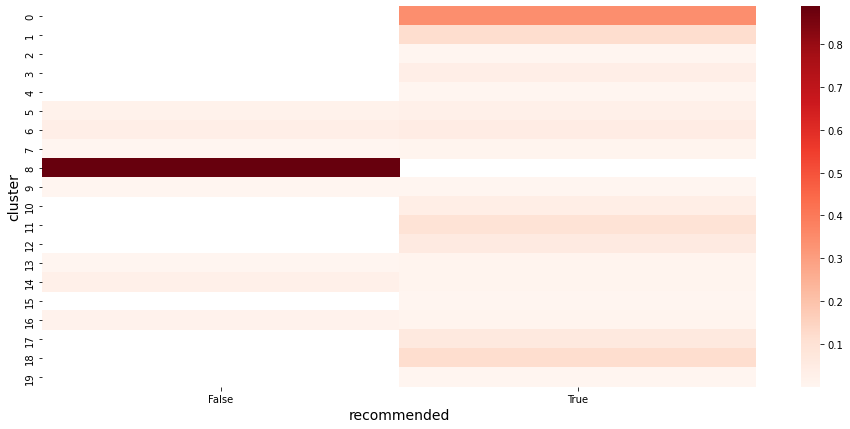

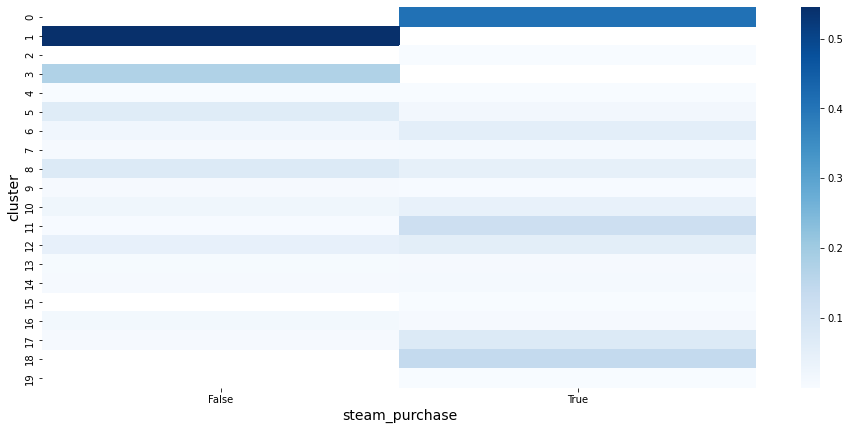

In [54]:
plot_heatmap(df_nlp)

**Conclusion from plots:** Separability is not lost, reasoning about the results is essentially the same as in the previous set up.

**2. Plots of the clusters with data projected to 2D and 3D using `pca` from Scikit Learn**

Let's check if the more smart preprocessing of the textual field along with appropriate feature engineering for the numerical ones influences scatter plots of clustering.

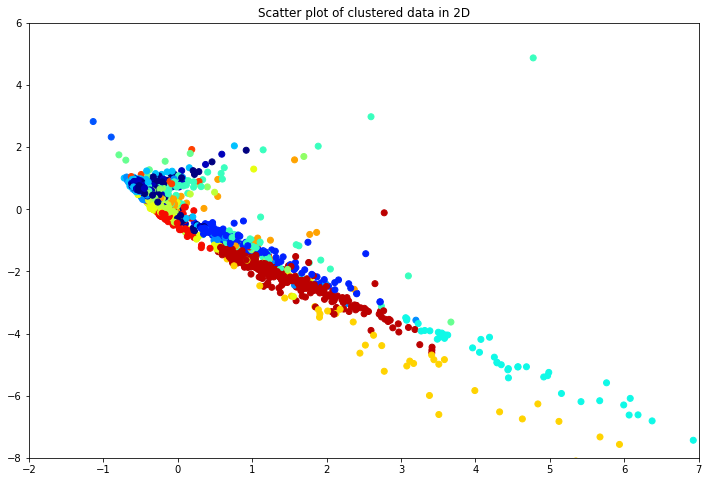

In [55]:
#2D scatter plot
plot_scatter(2, df_nlp, None, "nlp")

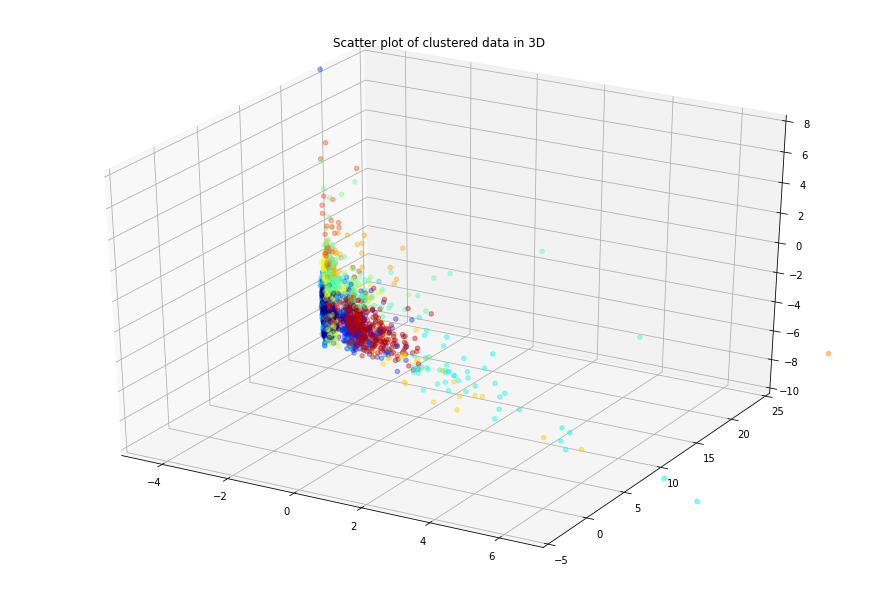

In [56]:
#3D scatter plot
plot_scatter(3, df_nlp, None, "nlp")

**Conclusion from plots:** The results are comparable with the results of the previous approach (2D projection is slightly better than before).


##**FE: PCA**

Dimensionality of the textual field could dominate the learning process, therefore an idea is to add to the previous experimental set up Dimensionality Reduction of the embedded **textual field** using **PCA**.

### **Preparation of the input data for the clustering**

In [57]:
def prepared_input_pca(df, n_components):

  #feature selection
  df = df.drop(['Unnamed: 0', 'review_id', 'app_id', 
                    'timestamp_created', 'timestamp_updated', 'weighted_vote_score',
                    'author.steamid', 'author.last_played', 'app_name'], axis = 1)
  
  #feature invention: add word counting feature
  df['word_count'] = df['review'].apply(lambda x: len(str(x).split(" ")))

  #compute average playtime amongst unique playtimes
  avg = np.average(df['author.playtime_forever'].unique())
  #feature invention: add has expertise feature
  df['has_expertise'] = [1 if playtime > avg else 0 for playtime in df['author.playtime_forever']]
  
  #leave only digital fields
  df_without_text = df.drop(['review'], axis = 1)

  #data normalization
  normalized_df = (df_without_text - df_without_text.mean()) / df_without_text.std()

  #review preprocessing
  review = prepared_input_nlp_text(df['review'])
  df = df[df.index.isin(review.index)]
  normalized_df = normalized_df[normalized_df.index.isin(review.index)]

  #pca
  pca = PCA(n_components = n_components)
  Xtrain_pca = pca.fit_transform(np.array(list(review)))

  #concatenation of all fields into a single input
  input = np.concatenate((Xtrain_pca, normalized_df.values), axis = 1)
  del review

  return df, input

In [ ]:
#resulting data type and shape
df_pca, data_pca = prepared_input_pca(df_mini.copy(), 3)

In [59]:
#textual review field projected to 3D + 14 numerical fields
print("DATA SHAPE:\n\n", data_pca.shape, "\n\nDATA:\n")
data_pca

DATA SHAPE:

 (4699, 17) 

DATA:



array([[ 1.13905018,  0.160321  ,  2.06126077, ..., -0.24859087,
        -0.39536502, -0.48490291],
       [ 0.41519615,  1.23444156, -0.97894974, ..., -0.29840931,
        -0.40749546, -0.48490291],
       [ 0.25091114, -0.28373923, -0.2595373 , ...,  0.67778447,
         2.77067993,  2.06185606],
       ...,
       [ 1.68692209, -0.155949  , -0.11724042, ..., -0.29857925,
        -0.39536502, -0.48490291],
       [ 0.90156013, -0.07672866, -0.09130922, ..., -0.24276415,
        -0.21340841, -0.48490291],
       [-1.28409248,  0.17268988, -0.22314103, ...,  0.90303568,
        -0.39536502,  2.06185606]])

### **Fitting the model with prepared data and fixed `k = 20`**

In [60]:
start = timeit.default_timer()

kmeans_pca = get_clusters(20, data_pca)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  1.4529510410000057


### **Plotting the results**

**1. Visualize the heatmaps to see how recommendations and purchases are clustered**

In [ ]:
#add the cluster label to the dataframe
df_pca = df_mini[df_mini.index.isin(df_pca.index)]
df_pca['cluster'] = kmeans_pca.labels_

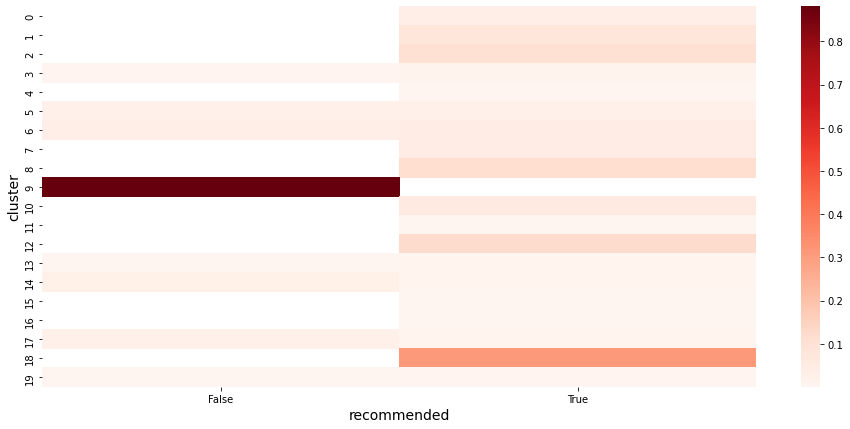

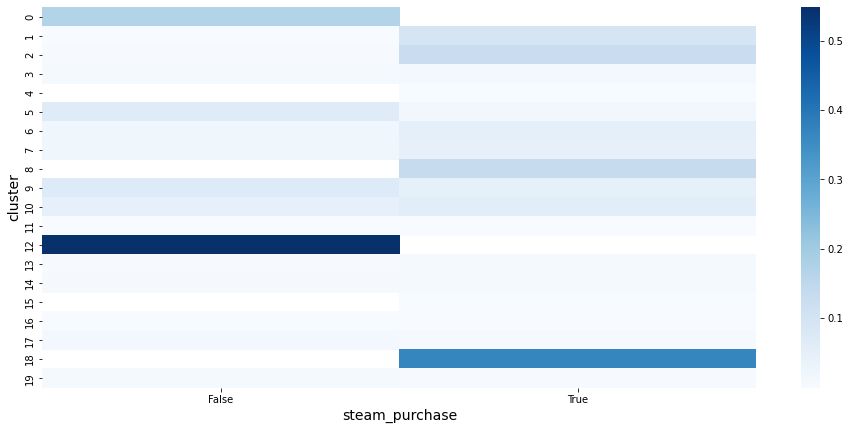

In [62]:
plot_heatmap(df_pca)

**Conclusion from plots:** Data is perfectly distributed over the slices of interest.

**2. Plots of the clusters with data projected to 2D and 3D using `pca` from Scikit Learn**

Here we display resulting scatter plots.

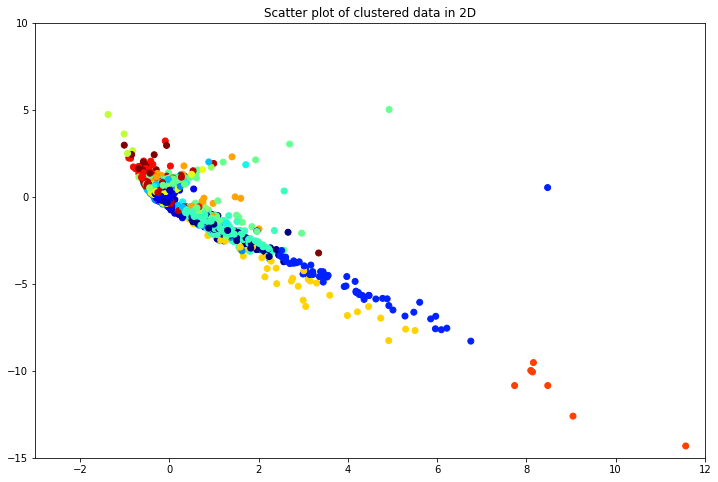

In [63]:
#2D scatter plot
plot_scatter(2, df_pca, None, "pca")

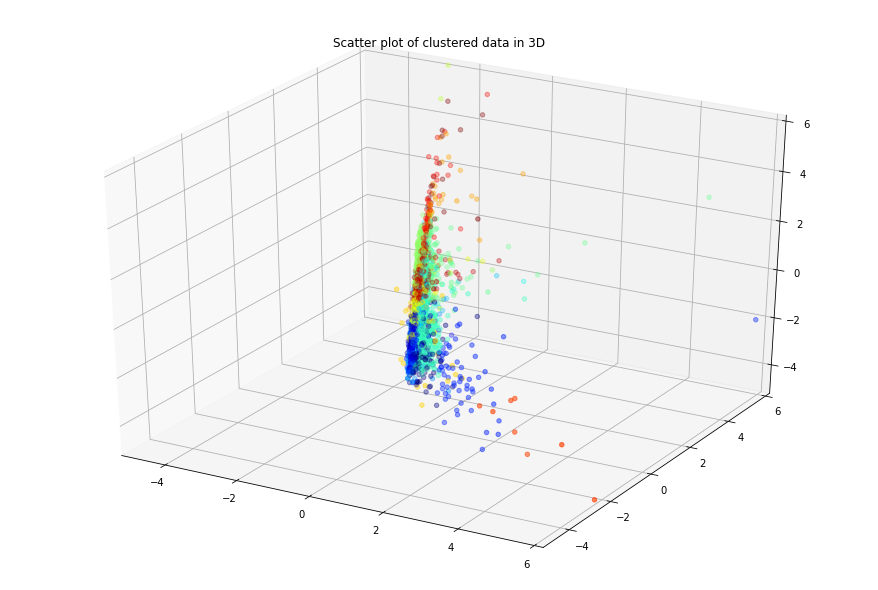

In [64]:
#3D scatter plot
plot_scatter(3, df_pca, None, "pca")

**Conclusion from plots:** Feature Engineering with PCA keeps approximately quality of clustering obtained so far, but saves the model from the "curse of dimensionality".